In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
import sys, os
import matplotlib.pyplot as plt
import random
import pickle as pkl
from collections import Counter, OrderedDict
import re

sys.path.append(os.path.abspath('../util'))
# sys.path.append(os.path.abspath('../'))

%matplotlib inline

In [3]:
def count_items(l, reverse = True):
    """Return ordered dictionary of counts of objects in `l`"""
    
    # Create a counter object
    counts = Counter(l)
    
    # Sort by highest count first and place in ordered dictionary
    counts = sorted(counts.items(), key = lambda x: x[1], reverse = reverse)
    counts = OrderedDict(counts)
    
    return counts

In [4]:
data_path = Path('../data/')
model_path = Path('../model/')
data = data_path / Path('data.csv')
# df_path= data_path / Path('df_cleaned__by_artist.csv')

CSV file contains float columns as features and using artist as a label for multiclass prediction.
If a song was produced by >1 artist the row has been split into mulitple rows so that each row only
has one artist.

In [5]:
df = pd.read_csv(data)
df.head()

,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,valence,year
0,0.995,['Carl Woitschach'],0.708,158648,0.1950,0,6KbQ3uYMLKb5jDxLF7wYDD,0.563,10,0.1510,-12.428,1,Singende Bataillone 1. Teil,0,1928,0.0506,118.469,0.7790,1928
1,0.994,"['Robert Schumann', 'Vladimir Horowitz']",0.379,282133,0.0135,0,6KuQTIu1KoTTkLXKrwlLPV,0.901,8,0.0763,-28.454,1,"Fantasiestücke, Op. 111: Più tosto lento",0,1928,0.0462,83.972,0.0767,1928
2,0.604,['Seweryn Goszczyński'],0.749,104300,0.2200,0,6L63VW0PibdM1HDSBoqnoM,0.000,5,0.1190,-19.924,0,Chapter 1.18 - Zamek kaniowski,0,1928,0.9290,107.177,0.8800,1928
3,0.995,['Francisco Canaro'],0.781,180760,0.1300,0,6M94FkXd15sOAOQYRnWPN8,0.887,1,0.1110,-14.734,0,Bebamos Juntos - Instrumental (Remasterizado),0,1928-09-25,0.0926,108.003,0.7200,1928
4,0.990,"['Frédéric Chopin', 'Vladimir Horowitz']",0.210,687733,0.2040,0,6N6tiFZ9vLTSOIxkj8qKrd,0.908,11,0.0980,-16.829,1,"Polonaise-Fantaisie in A-Flat Major, Op. 61",1,1928,0.0424,62.149,0.0693,1928


In [6]:
[a.strip('[] ').replace("'", '') for a in df.artists[1].split(',')]

['Robert Schumann', 'Vladimir Horowitz']

In [7]:
artists_names = df.artists

In [8]:
def func(x):
    return [a.strip('[] ').replace("'", '') for a in x.split(',')]    

In [9]:
artists_list = artists_names.apply(func)

In [10]:
a_list = pd.DataFrame(artists_list)

In [11]:
def func_2(x, val=2):
    return len(list(x)[0])>=val

In [12]:
colab_artists = a_list[a_list.apply(func_2, axis=1)]

In [13]:
colab_artists

,artists
1,"[Robert Schumann, Vladimir Horowitz]"
4,"[Frédéric Chopin, Vladimir Horowitz]"
5,"[Felix Mendelssohn, Vladimir Horowitz]"
6,"[Franz Liszt, Vladimir Horowitz]"
8,"[Francisco Canaro, Charlo]"
...,...
169903,"[LEGADO 7, Junior H]"
169904,"[DripReport, Tyga]"
169905,"[Leon Bridges, Terrace Martin]"
169906,"[Kygo, Oh Wonder]"


In [14]:
pair_set = list()

for artists in colab_artists.iterrows():
    for i, a in enumerate(range(len(artists[1][0]))):
        if i!= len(artists[1][0])-1:
#             print(artists[1][0])
#             print((artists[1][0][i], artists[1][0][i+1]))
#             print('*'*10)
            pair_set.append((artists[1][0][i], artists[1][0][i+1]))

In [15]:
len(pair_set)

56904

In [16]:
count_d = {}

for a1,a2 in pair_set:
    if not a1 in count_d.keys():
        count_d[a1] = 1
    if not a2 in count_d.keys():
        count_d[a2] = 1
    else:
        count_d[a1] +=1
        count_d[a2] +=1

In [17]:
count_d['Drake']

204

In [18]:
sorted(count_d.items(), key = lambda x: x[1], reverse = False)[:10]

[('S. Loukopoulos', 1),
 ('Elvira Nte Ntalgko', 1),
 ('Gene Sedric', 1),
 ('Al Casey', 1),
 ('Jimmie Lunceford & His Orchestra', 1),
 ('Klarino Har. Margels', 1),
 ('Giorgos Mpekas', 1),
 ('Polixeni LItou', 1),
 ('Dimitris Gkogkos', 1),
 ('Oρχήστρα Β.Reibold', 1)]

In [19]:
len(count_d.keys()), len(pair_set)

(15155, 56904)

In [20]:
index_artist = dict(((i, artist) for i,artist in  enumerate(count_d.keys())))
artist_index = dict((val, key) for key,val in index_artist.items() )

In [21]:
len(artist_index), len(index_artist), len(pair_set)

(15155, 15155, 56904)

In [22]:
artist_index['Kehlani'], artist_index['Drake']

(2097, 1812)

In [23]:
idx = 1

In [24]:
(index_artist[artist_index[pair_set[idx][0]]], index_artist[artist_index[pair_set[idx][1]]]) 

('Frédéric Chopin', 'Vladimir Horowitz')

# Model

- Create a generator with True/ Fake samples
    - Fake samples: Choose a random vector and assign a label that is not its true artist label (1/0)
- Create an embedding layer for the artists and pass the remaining features to a FC layer
- Train the model to see if it can detect fakes (BCE)
- User inputs song
    - Featurize the song using spotify api
    - Input the features into model(Artist in dict | Artist not in dict)
    - Works for Artist in dict, if artist not in dict???

In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter

In [26]:
# T -> Get value form pair_set 
# F -> Get 2 random values from count_d
#   -> Check if they are not is pair_set 
#   -> Add them to F dataset

In [27]:
(index_artist[random.choice(range(0,len(count_d)))], index_artist[random.choice(range(0,len(count_d)))] ) in pair_set

False

In [28]:
class Dataset(torch.utils.data.Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, pair_set, count_d, is_truth = 1):
        'Initialization'
        self.ps = pair_set
        self.count_d = count_d
        self.is_truth = is_truth

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.ps)-1

    def __getitem__(self, index):
        'Generates one sample of data'
        true_label = 1
        fake_label = -1
        
        if self.is_truth:     
            return (artist_index[pair_set[index][0]], artist_index[pair_set[index][1]]),\
                        torch.tensor([true_label])
        else:        
            a1 = index_artist[random.choice(range(0,len(count_d)))]
            a2 = index_artist[random.choice(range(0,len(count_d)))]
            if (a1, a2) not in pair_set:
                return (artist_index[a1], artist_index[a2]),\
                        torch.tensor([fake_label])
            else:
                a1 = index_artist[random.choice(range(0,len(count_d)))]
                a2 = index_artist[random.choice(range(0,len(count_d)))]
                if (a1, a2) not in pair_set:
                    return (artist_index[a1], artist_index[a2]),\
                            torch.tensor([fake_label])
                else: 
                    return (artist_index[a1], artist_index[a2]),\
                            torch.tensor([true_label])

In [29]:
class DeepEmbed(nn.Module):

    def __init__(self, feature_size, lookup_size, embedding_dim, batch_size):
        super(DeepEmbed, self).__init__()
        self.embedding_dim = embedding_dim
        # Should Input size be (None,1) ?         
        self.embeddings1 = nn.Embedding(lookup_size, embedding_dim)
        self.embeddings2 = nn.Embedding(lookup_size, embedding_dim)
        
#         self.linear1 = nn.Linear(embedding_dim, 128)
#         self.linear2 = nn.Linear(embedding_dim, 128)
        
#         self.head = nn.Linear(256, 128)
#         self.op_layer = nn.Linear(128, 1)
#         self.op_layer = nn.Linear(256, 128)
        
        
        self.batch_size = batch_size

    def forward(self, ip1, ip2):
        embeds1 = self.embeddings1(ip1).view(self.batch_size, 1, -1)
#         out1 = self.linear1(embeds1)
        embeds2 = self.embeddings2(ip2).view(self.batch_size, 1, -1)
#         out2 = self.linear2(embeds2)
        dot = torch.bmm(embeds1.view(-1, 1, self.embedding_dim), embeds2.view(-1, self.embedding_dim, 1)) 
#         print(dot.shape)
#         out2 = F.relu(self.head(feature_input))
#         output_concat = torch.cat([out1, out2], axis =-1)
#         head = F.leaky_relu(self.head(output_concat))
#         op = self.op_layer(head)
#         op = self.op_layer_2(op)
        out = dot
        return out.squeeze(1)

In [30]:
# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
torch.backends.cudnn.benchmark = True

In [31]:
truth_set = Dataset(pair_set, count_d, is_truth=True)
fake_set = Dataset(pair_set, count_d, is_truth=False)

full_ds = torch.utils.data.ConcatDataset([truth_set, fake_set])
# training_generator = torch.utils.data.DataLoader(training_set, **params)

In [32]:
lookup_size = len(artist_index)
emb_dim = 50
feature_size = len(df.columns)
learning_rate = 0.01
batch_size = 512
epochs = 50

criterion = nn.MSELoss()

In [33]:
train_dl = torch.utils.data.DataLoader(full_ds, batch_size=batch_size, shuffle=True, num_workers=2)
_iter = iter(train_dl)

In [34]:
a1 = next(_iter)

In [35]:
(index_artist[int(851)], index_artist[int(380)]) in pair_set

True

In [36]:
model = DeepEmbed(feature_size = feature_size, lookup_size=lookup_size, \
                  embedding_dim=emb_dim, batch_size=batch_size)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

print(model.parameters)

<bound method Module.parameters of DeepEmbed(
  (embeddings1): Embedding(15155, 50)
  (embeddings2): Embedding(15155, 50)
)>


In [37]:
def train(model, device, train_loader, optimizer, criterion):
    model.train()
    y_true = []
    y_pred = []
    for epoch in range(epochs):
        if epoch %10 == 9 :
            print(f"--EPOCH {epoch}--")
        for i in train_loader:
#             print(i)
            (a1, a2), label = i
            a1, a2, label = a1.cuda(), a2.cuda(),label.cuda()
            label = label.float()
            output = model(a1, a2)

            loss = criterion(output, label) 
            writer.add_scalar("Loss/train", loss, epoch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            if epoch %10 == 9 :
                print(f"{loss.item()}")
            break

In [38]:
train_model = False
writer = SummaryWriter()

In [39]:
if train_model == True:
    train(model.cuda(), device, train_dl, optimizer, criterion)
    torch.save(model.state_dict(),model_path/'new_model.ckpt' )
    writer.flush()
    writer.close()
else:
    model.load_state_dict(torch.load(str(model_path/'new_model.ckpt' )))

In [40]:
# emb(torch.tensor([1]))

In [41]:
# d = dict() 
# for i in range(0, len(artist_index)):
#     d[index_artist[i]] = emb(torch.tensor([i])).detach().numpy()

In [42]:
# with open(model_path/ 'n_deep_embeddings.pkl', 'wb') as handle:
#     pkl.dump(d, handle, protocol=pkl.HIGHEST_PROTOCOL)

In [43]:
def find_similar(name, weights, index_name, n = 10, least = False, return_dist = False, plot = False):
    """Find n most similar items (or least) to name based on embeddings. Option to also plot the results"""
    

    index = artist_index
    rindex = index_artist
    try:
        # Calculate dot product between book and all others
        dists = np.dot(weights, weights[index[name]])
    except KeyError:
        print(f'{name} Not Found.')
        return
    
    # Sort distance indexes from smallest to largest
    sorted_dists = np.argsort(dists)
    
    # Plot results if specified
    if plot:
        
        # Find furthest and closest items
        furthest = sorted_dists[:(n // 2)]
        closest = sorted_dists[-n-1: len(dists) - 1]
        items = [rindex[c] for c in furthest]
        items.extend(rindex[c] for c in closest)
        
        # Find furthest and closets distances
        distances = [dists[c] for c in furthest]
        distances.extend(dists[c] for c in closest)
        
        colors = ['r' for _ in range(n //2)]
        colors.extend('g' for _ in range(n))
        
        data = pd.DataFrame({'distance': distances}, index = items)
        
        # Horizontal bar chart
        data['distance'].plot.barh(color = colors, figsize = (10, 8),
                                   edgecolor = 'k', linewidth = 2)
        plt.xlabel('Cosine Similarity');
        plt.axvline(x = 0, color = 'k');
        
        # Formatting for italicized title
        name_str = f'{index_name.capitalize()}s Most and Least Similar to'
        for word in name.split():
            # Title uses latex for italize
            name_str += ' $\it{' + word + '}$'
        plt.title(name_str, x = 0.2, size = 28, y = 1.05)
        
        return None
    
    # If specified, find the least similar
    if least:
        # Take the first n from sorted distances
        closest = sorted_dists[:n]
         
        print(f'{index_name.capitalize()}s furthest from {name}.\n')
        
    # Otherwise find the most similar
    else:
        # Take the last n sorted distances
        closest = sorted_dists[-n:]
        
        # Need distances later on
        if return_dist:
            return dists, closest
        
        
        print(f'{index_name.capitalize()}s closest to {name}.\n')
        
    # Need distances later on
    if return_dist:
        return dists, closest
    
    
    # Print formatting
    max_width = max([len(rindex[c]) for c in closest])
    
    # Print the most similar and distances
    for c in reversed(closest):
        print(f'{index_name.capitalize()}: {rindex[c]:{max_width + 2}} Similarity: {dists[c]:.{2}}')

In [54]:
emb = model.embeddings2.cpu()

In [55]:
data_arr = emb.weight.detach().numpy()
data_arr.shape

(15155, 50)

In [ ]:
data_arr = data_arr / np.linalg.norm(data_arr, axis = 1).reshape((-1, 1))
data_arr[0][:10]
np.sum(np.square(data_arr[0]))

In [47]:
name = "Drake"

In [56]:
find_similar(name, data_arr, 'artist', n=15)

Artists closest to Drake.

Artist: Drake                   Similarity: 4.9e+01
Artist: Adalberto Santiago      Similarity: 2.4e+01
Artist: Sylk                    Similarity: 2.4e+01
Artist: Labati Carlo Donida     Similarity: 2.3e+01
Artist: Kebo Gotti              Similarity: 2.2e+01
Artist: Remo Giazotto           Similarity: 2.2e+01
Artist: 10                      Similarity: 2.2e+01
Artist: Bizarre                 Similarity: 2.2e+01
Artist: Ruben                   Similarity: 2.2e+01
Artist: Priscilla Gillette      Similarity: 2.2e+01
Artist: Cap                     Similarity: 2.1e+01
Artist: Noah Kahan              Similarity: 2.1e+01
Artist: Tish Planes             Similarity: 2.1e+01
Artist: The Salsoul Orchestra   Similarity: 2.1e+01
Artist: Rudolf Duda             Similarity: 2.1e+01


In [49]:
from sklearn.manifold import TSNE
from umap import UMAP

In [50]:
def reduce_dim(weights, components = 3, method = 'tsne'):
    """Reduce dimensions of embeddings"""
    if method == 'tsne':
        return TSNE(components, metric = 'cosine').fit_transform(weights)
    elif method == 'umap':
        # Might want to try different parameters for UMAP
        return UMAP(n_components=components, metric = 'cosine', 
                    init = 'random', n_neighbors = 5).fit_transform(weights)

In [57]:
emb = model.embeddings1.cpu()
data_arr = emb.weight.detach().numpy()

In [58]:
tsne = reduce_dim(data_arr, components = 2, method = 'umap')
tsne.shape

(15155, 2)

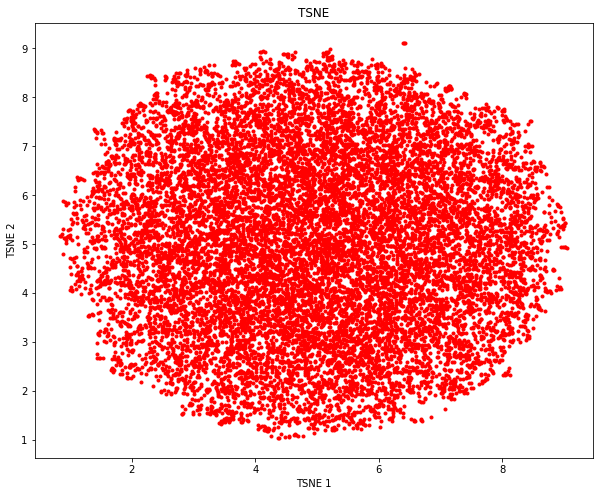

In [59]:
# InteractiveShell.ast_node_interactivity = 'last'

plt.figure(figsize = (10, 8))
plt.plot(tsne[:, 0], tsne[:, 1], 'r.')
plt.xlabel('TSNE 1'); plt.ylabel('TSNE 2'); plt.title('TSNE');